## Clustering visualization

This notebook will be used for the visualization of the subspace-defining cluster using different techniques and under different clusterings.

We will load an existing clustering and then visualize it using different techniques.

In [1]:
# Include and load packages, config files
import sys
sys.path.append('..')
import numpy as np
import simlr_ad
import pandas as pd
from utils.data_utils import load_all_data, load_covariates
from utils.utils import compute_simlr, feat_ranking, estimate_number_clusters, estimate_number_clusters_cimlr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Parameters of the procedure
clusters = 4
rd_seed = 1714                                          # Random seed for experiment replication

# Paths
existing_cluster = True                                              # Compute the clustering again or use an existing one
cluster_path = "/home/gerard/Documents/EXPERIMENTS/SIMLR-AD/cimlr4long/"# Path of the existing cluster, if applicable
covariate_path = "../long_data/covariates_long.csv"       # Path of the covariance data frame (.csv)
#feature_path = "../data/aseg_volume.csv"                # Path of the feature file, generated with freesurfer (.csv)

# covariate_data, cov_names, feature_data, feature_names = load_all_data(covariate_path, feature_path)
covariate_data, cov_names = load_covariates(covariate_path, normalize=True)

if existing_cluster:
    # Load existent
    c_data = pd.read_csv(cluster_path + 'cluster_data.csv')
    c_data.reset_index(inplace=True)
    ## Load S, F data
    S = np.load(cluster_path + 'S_matrix.npy')
    ydata = np.load(cluster_path + 'ydata_matrix.npy')
    F = np.load(cluster_path + 'F_matrix.npy')
    alpha = np.load(cluster_path + 'alpha.npy')
else:
    # Compute base clustering
    y_b, S, F, ydata, alpha = compute_simlr(
        np.array(covariate_data[cov_names]), clusters)

# Preprocess S matrix

S_old = (S - min(S.flatten())) / (max(S.flatten())-min(S.flatten())) 
S = (1-S_old)
from sklearn.metrics.pairwise import euclidean_distances
S_euclidean = euclidean_distances(covariate_data[cov_names], covariate_data[cov_names])
S_euc_new = (1-S_euclidean)

How to determine number of clusters: 
    
* First, based on the method from the paper.

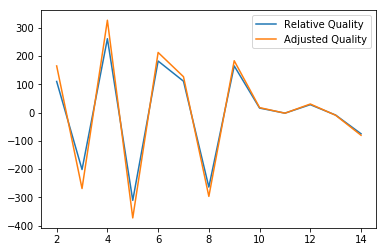

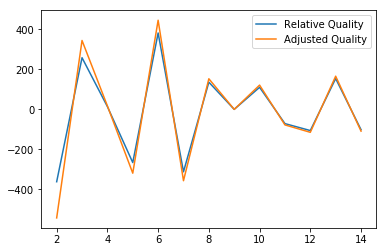

In [2]:
# Visualize possible number of clusters
K1, K2, n_list = estimate_number_clusters(np.array(covariate_data[cov_names]))

plt.plot(n_list, K1, label='Relative Quality')
plt.plot(n_list, K2, label='Adjusted Quality')
plt.legend()
plt.show()

K1, K2, n_list = estimate_number_clusters_cimlr(np.array(covariate_data[cov_names]))

plt.plot(n_list, K1, label='Relative Quality')
plt.plot(n_list, K2, label='Adjusted Quality')
plt.legend()
plt.show()

* Using the elbow method

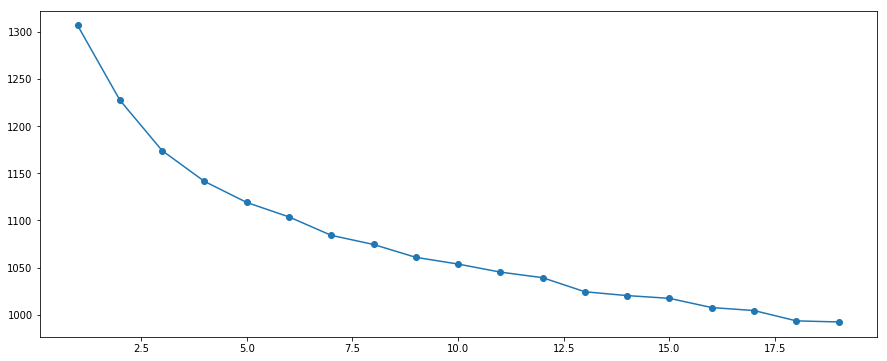

In [3]:
from sklearn.cluster import KMeans
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    cclusters = KMeans( num_clusters )
    cclusters.fit( np.array(covariate_data[cov_names]) )
    cluster_errors.append( cclusters.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

plt.figure(figsize=(15,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [4]:
## Visualize the similarity matrix

# Sort the similarity matrices using the clustering labels
c_data_sorted = c_data.sort_values(['C'])
index = c_data_sorted.index.values

S_old = S_old[index, :]
S_old = S_old[:, index]

S_euclidean = S_euclidean[index, :]
S_euclidean = S_euclidean[:, index]

In [5]:
## Use t-SNE to visualize the clusters with the CIMLR
from sklearn.manifold import TSNE
ts = TSNE(n_components=2, perplexity = 25.0, early_exaggeration = 30.0, learning_rate = 100.0, metric='precomputed')
space = ts.fit_transform(S)

In [6]:
## Use t-SNE to visualize the clusters with the euclidean matrix
from sklearn.manifold import TSNE
ts = TSNE(n_components=2, perplexity = 25.0, early_exaggeration = 30.0, learning_rate = 100.0, metric='precomputed')
space_euc = ts.fit_transform(S_euclidean)

Figure comparing the clustering and the similarity matrix.

Create a 2x2 subplot matrix, where:
* The top row will have the two similarity matrices, for euclidean distance and for 
* The bottom row have the two dimensional representation with t-SNE of each of the matrices

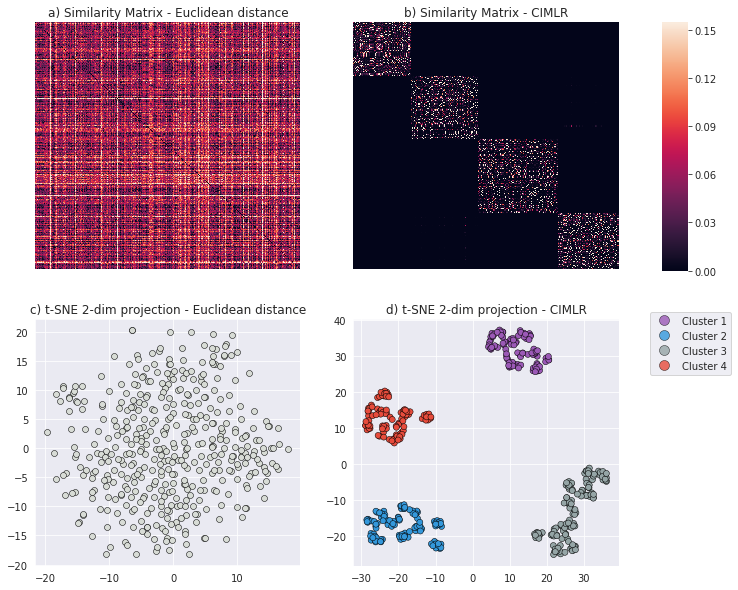

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

sns.set_style("darkgrid")
f, axarr = plt.subplots(2, 2)
f.set_size_inches(12, 10)

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

# Set titles of the plots
axarr[0][0].set_title('a) Similarity Matrix - Euclidean distance')
axarr[0][1].set_title('b) Similarity Matrix - CIMLR')
axarr[1][0].set_title('c) t-SNE 2-dim projection - Euclidean distance')
axarr[1][1].set_title('d) t-SNE 2-dim projection - CIMLR')

# Matrix with euclidean
t1 = sns.heatmap(S_euclidean, robust=True, cbar=False, xticklabels=False, yticklabels=False, ax=axarr[0][0], rasterized=True)

# Matrix with SIMLR
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.535, 0.03, 0.345])
t2 = sns.heatmap(S_old, robust=True, cbar=True, cbar_ax=cbar_ax, xticklabels=False, yticklabels=False, ax=axarr[0][1], rasterized=True)

# T-SNE with CIMLR
axarr[1][1].scatter(space[:, 0], space[:, 1], c=c_data['C'].values, marker='o', edgecolor='black', linewidth=0.5, alpha=1.0, cmap=my_cmap)

# T-SNE with euclidean distance 
axarr[1][0].scatter(space_euc[:, 0], space_euc[:, 1], c='xkcd:light grey', marker='o', edgecolor='black', linewidth=0.5, alpha=1.0)
legend = [Line2D([0], [0], marker='o', markeredgecolor='black', markeredgewidth=0.5, linewidth=0, alpha=0.8, markerfacecolor='#9b59b6', label='Cluster 1', markersize=10),
          Line2D([0], [0], marker='o', markeredgecolor='black', markeredgewidth=0.5, linewidth=0, alpha=0.8, markerfacecolor='#3498db', label='Cluster 2', markersize=10),
          Line2D([0], [0], marker='o', markeredgecolor='black', markeredgewidth=0.5, linewidth=0, alpha=0.8, markerfacecolor='#95a5a6', label='Cluster 3', markersize=10),
          Line2D([0], [0], marker='o', markeredgecolor='black', markeredgewidth=0.5, linewidth=0, alpha=0.8, markerfacecolor='#e74c3c', label='Cluster 4', markersize=10)]
axarr[1][1].legend(handles=legend, loc='center left', bbox_to_anchor=(1.1, 0.9))


plt.axis('tight')
# plt.savefig('cluster_results_full.png',bbox_inches='tight')
plt.savefig('Fig3.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

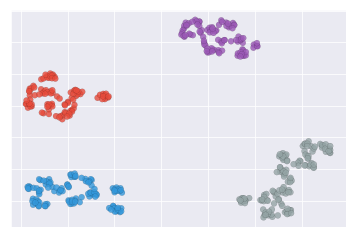

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline
sns.set_style("darkgrid")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

plt.scatter(space[:, 0], space[:, 1], c=c_data['C'].values, marker='o', edgecolor='black', linewidth=0.1, alpha=0.8, cmap=my_cmap)
plt.axis('tight')
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.savefig('simlr_figure.svg', format='svg', dpi=300)
plt.show()

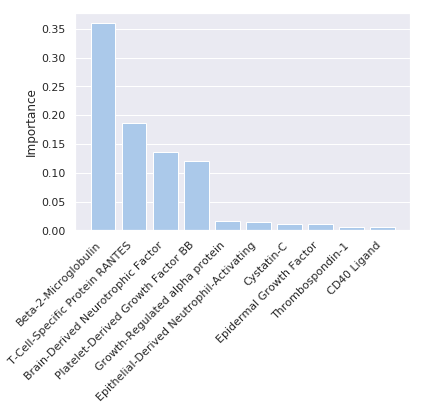

In [9]:
## Visualize feature importance

# First, create feature importance
feat_imp = []
for i in range(len(cov_names)):
    values = alpha[15*i:15*i+15]
    feat_imp.append(sum(values))

# Print the figure
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

values = pd.DataFrame(data={"Markers": cov_names,
                            "Importance": feat_imp})


values = values.sort_values(by='Importance', ascending=False)
values.to_csv('values_with_markers.csv', index=False)
names_original = values[0:10].Markers.values

# Change names for better fig visualization
values["norm_values"] = (feat_imp - np.min(feat_imp)) / (np.max(feat_imp)-np.min(feat_imp))
plt.figure()

sns.set_color_codes("pastel")
sns.barplot(x="Markers", y="Importance", data=values.iloc[0:10],
           label="Importance", color="b")
plt.xticks(np.arange(10), ('Beta-2-Microglobulin', 'T-Cell-Specific Protein RANTES', 'Brain-Derived Neurotrophic Factor',
                           'Platelet-Derived Growth Factor BB', 'Growth-Regulated alpha protein',
                           'Epithelial-Derived Neutrophil-Activating', 'Cystatin-C', 
                           'Epidermal Growth Factor', 'Thrombospondin-1', 'CD40 Ligand'), rotation=45, ha="right")
plt.xlabel('')
plt.axis('tight')
plt.savefig('Fig4.eps', format='eps', dpi=300, bbox_inches='tight')
#plt.savefig('figures_svg/cluster_importance.svg', format='svg')
# plt.savefig('cluster_importance.png',bbox_inches='tight')

In [10]:
# Create table of mean and std of values for each of the clusters for those:
# Copy from the main

df_results = pd.DataFrame(index=names_original)
# For different clusters
for c in range(1, clusters+1):
    print('Cluster ' + str(c))
    c1 = covariate_data[c_data['C'].values == c]

    data_cluster = []
    statistics = c1[names_original].describe()
    for feat in names_original:
        data_cluster.append('$' + "{:.2f}".format(statistics.loc["mean",feat]) + '\pm' + "{:.2f}".format(statistics.loc["std",feat])  + '$')
    df_results[c] = pd.Series(data_cluster, index=df_results.index)

# In total
data_cluster = []
statistics = covariate_data[names_original].describe()

for feat in names_original:
    data_cluster.append('$' + "{:.2f}".format(statistics.loc["mean",feat]) + '\pm' + "{:.2f}".format(statistics.loc["std",feat])  + '$')

# ANOVA tests
import scipy.stats as stats
ANOVA_tests=[]
for feat in names_original:
    c1 = covariate_data[c_data['C'].values == 1]
    c2 = covariate_data[c_data['C'].values == 2]
    c3 = covariate_data[c_data['C'].values == 3]
    c4 = covariate_data[c_data['C'].values == 4]
    fval, pval = stats.f_oneway(c1[feat],c2[feat],c3[feat],c4[feat])
    ANOVA_tests.append(pval)
    
# df_results["ANOVA test"] = pd.Series(ANOVA_tests, index=df_results.index)
df_results["Total"] = pd.Series(data_cluster, index=df_results.index)

df_results.to_csv(cluster_path+'cluster_stats_covariates.csv')

Cluster 1
Cluster 2
Cluster 3
Cluster 4


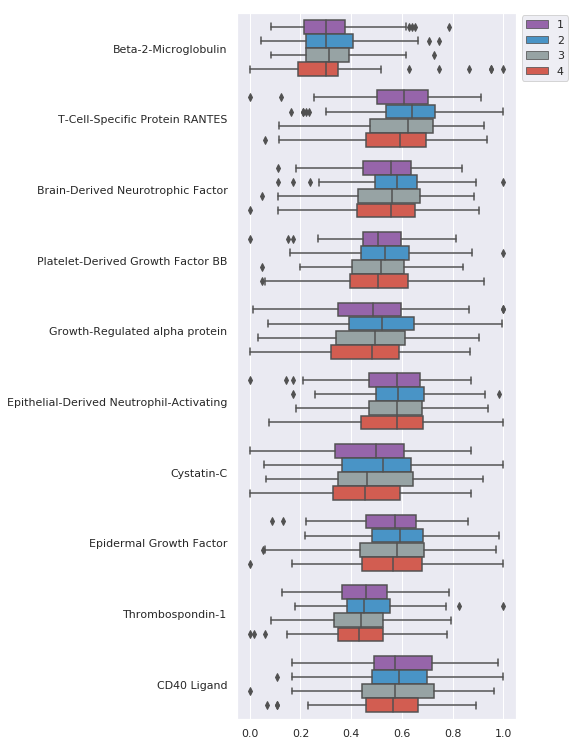

In [11]:
# Create a boxplot figure of results
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline
sns.set_style("darkgrid")
plt.figure(figsize=(5,13))
# Propose the data
covariate_data = covariate_data[names_original]

# Create new names, assign new names to new dataframe
# new names without the units, to make figure more legible.
new_names = ["Beta-2-Microglobulin", "T-Cell-Specific Protein RANTES", "Brain-Derived Neurotrophic Factor",
             "Platelet-Derived Growth Factor BB", "Growth-Regulated alpha protein",
             "Epithelial-Derived Neutrophil-Activating", "Cystatin-C", "Epidermal Growth Factor", "Thrombospondin-1",
             "CD40 Ligand"]

# Even newer names
"""
new_names = ["Beta-2-Microglobulin (B2M)", "CCL5 (RANTES)", "Brain-Derived Neurotrophic Factor (BDNF)",
             "Platelet-Derived Growth Factor BB (PDGF-BB)", "Growth-Regulated alpha protein (GRO-alpha)",
             "Epithelial-Derived Neutrophil-Activating (ENA-78)", "Cystatin-C", "Epidermal Growth Factor (EGF)", "Thrombospondin-1 (THBS1)",
             "CD40 Ligand"]
"""

covariate_data.columns = new_names
names_original = new_names

covariate_data['C'] = c_data.C.values.astype(int).astype(str)
# Add C
names_original_c = np.append(names_original, ['C'])
# Draw a nested boxplot to show bills by day and sex
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

df_test = pd.melt(covariate_data[names_original_c], id_vars=['C'], value_vars=names_original, var_name='markers', value_name='values')
sns.boxplot(x='values', y='markers', hue='C', data=df_test, palette=sns.color_palette(flatui), orient='h')
plt.ylabel('')
plt.xlabel('')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.95))
# sns.despine(offset=10, trim=True)
plt.savefig('Fig5.eps', format='eps', dpi=300, bbox_inches='tight')
# plt.savefig('cluster_dist.png', bbox_inches='tight')

In [ ]:
## Create a 30x10 random matrix of gaussian variables, show it in a barebones heatplot
matrix = np.random.normal(size=(50,10))

# Matrix with euclidean
plt.figure(figsize=(6,12))
sns.heatmap(matrix, robust=True, cbar=False, xticklabels=False, yticklabels=False)
plt.axis('tight')
plt.savefig('figures_svg/matrix_fig1.svg', format='svg')